# ripple match verification

In [46]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import jax
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

# ripple test notebook implementing the random match
import sys
sys.path.append('../../ripple/test/')
from benchmark_waveform import random_match

%load_ext autoreload
%autoreload 2

params = {"axes.grid": True,
          "text.usetex" : True,
          "font.family" : "serif",
          "ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16,
          "figure.titlesize": 16}

plt.rcParams.update(params)

### Auxiliary functions
def get_chi_eff(chi1, chi2, m1, m2):
    return (chi1 * m1 + chi2 * m2) / (m1 + m2)

def get_chirp_mass(m1, m2):
    return (m1 * m2)**(3/5) / (m1 + m2)**(1/5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preamble

Toggle this to true in case we want to rerun things

In [47]:
RUN_BENCHMARK_WAVEFORM = False

## Run the ripple match verification

In [48]:
N_samples = 1_000
bounds = {"m": [0.5, 3.0],
          "chi": [-1, 1],
          "lambda": [0, 5000],
          "d_L": [1, 400]
        }

outdir = "../data/"

approximant_list = ["IMRPhenomD", "TaylorF2", "IMRPhenomD_NRTidalv2"]
if RUN_BENCHMARK_WAVEFORM:
  for approximant in approximant_list:
      print(f"Checking {approximant}")
      random_match(N_samples, bounds, approximant, outdir, "../data/psds/psd.txt")

## Read in mismatch data

In [49]:
# Choose tidal waveform here
approximant_names = ["IMRPhenomD",
                     "IMRPhenomD_NRTidalv2", 
                     "TaylorF2"]

approximant_names_latex = [r"IMRPhenomD",
                           r"IMRPhenomD\_NRTidalv2", 
                           r"TaylorF2"]

matches_dict = {}
for approximant in approximant_names:

    matches_filename = os.path.join(os.getcwd(), f"../data/matches_data/matches_{approximant}.csv")
    print(f"Reading in matches from {matches_filename}")
    matches_df = pd.read_csv(matches_filename)

    ### Get the values
    m1_values = matches_df["m1"].values
    m2_values = matches_df["m2"].values
    q_values = matches_df["m2"] / matches_df["m1"].values
    chi1_values = matches_df["chi1"].values
    chi2_values = matches_df["chi2"].values
    mismatch_values = matches_df["mismatch"].values
    if approximant != "IMRPhenomD":
        lambda1_values = matches_df["lambda1"].values
        lambda2_values = matches_df["lambda2"].values
    else:
        lambda1_values = np.zeros(len(m1_values))
        lambda2_values = np.zeros(len(m1_values))

    # Add matches to dictionary
    matches_dict[approximant] = {} 
    matches_dict[approximant]["m1"] = m1_values
    matches_dict[approximant]["m2"] = m2_values
    matches_dict[approximant]["q"] = q_values
    matches_dict[approximant]["chi1"] = chi1_values
    matches_dict[approximant]["chi2"] = chi2_values
    matches_dict[approximant]["mismatch"] = mismatch_values
    matches_dict[approximant]["lambda1"] = lambda1_values
    matches_dict[approximant]["lambda2"] = lambda2_values

Reading in matches from /Users/Woute029/Documents/Code/TurboPE-BNS/postprocessing/../data/matches_data/matches_IMRPhenomD.csv
Reading in matches from /Users/Woute029/Documents/Code/TurboPE-BNS/postprocessing/../data/matches_data/matches_IMRPhenomD_NRTidalv2.csv
Reading in matches from /Users/Woute029/Documents/Code/TurboPE-BNS/postprocessing/../data/matches_data/matches_TaylorF2.csv


## Plot the mismatch histograms

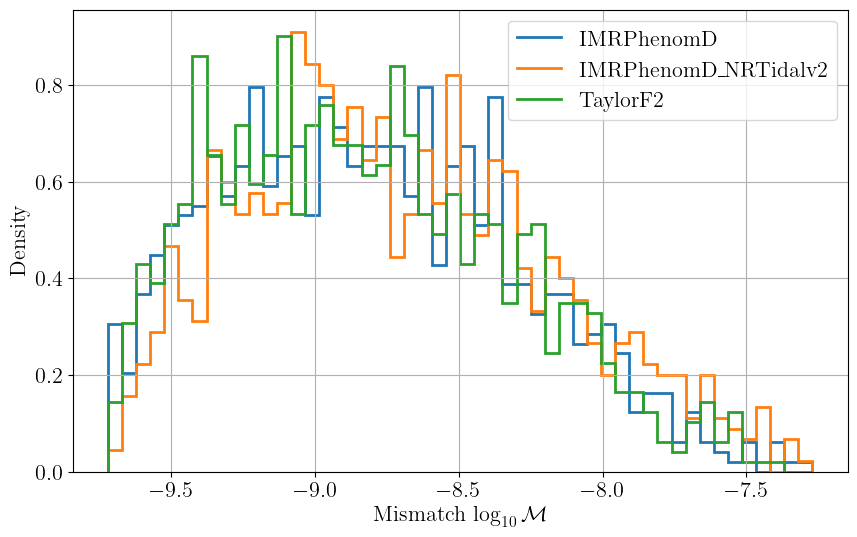

In [50]:
plt.figure(figsize = (10, 6))
counter = 0
for key, value in matches_dict.items():
    latex_label = approximant_names_latex[counter]
    mismatch_values = value["mismatch"]
    if counter == 0:
        counts, bins = np.histogram(mismatch_values, bins = 50, density=True)
    else:
        counts, _ = np.histogram(mismatch_values, bins = bins, density=True)
    plt.stairs(counts, bins, linewidth=2, label=latex_label)
    # plt.hist(mismatch_values, bins=50, histtype='step', linewidth=3, density=True, label=latex_label)
    
    counter += 1

plt.xlabel(r"Mismatch $\log_{10} \mathcal{M}$")
plt.legend()
plt.ylabel("Density")
plt.savefig("../figures/mismatch_histogram.pdf", bbox_inches="tight")
plt.show()

### Sanity check: without enforcing the bins to be the same

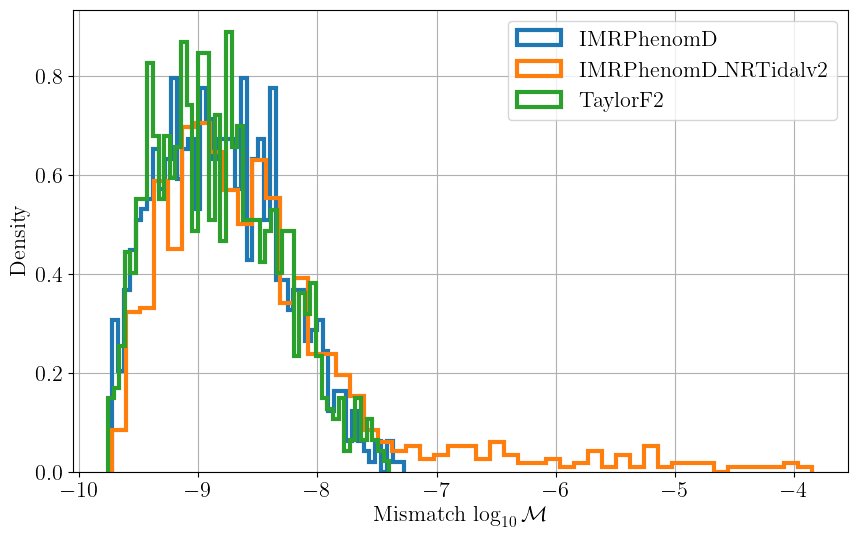

In [51]:
plt.figure(figsize = (10, 6))
counter = 0
for key, value in matches_dict.items():
    latex_label = approximant_names_latex[counter]
    mismatch_values = value["mismatch"]
    plt.hist(mismatch_values, bins=50, histtype='step', linewidth=3, density=True, label=latex_label)
    # plt.hist(mismatch_values, bins=50, histtype='step', linewidth=3, density=True, label=latex_label)
    
    counter += 1

plt.xlabel(r"Mismatch $\log_{10} \mathcal{M}$")
plt.legend()
plt.ylabel("Density")
# plt.savefig("../figures/mismatch_histogram.pdf", bbox_inches="tight")
plt.show()

## Extra: check sampled parameters

In [52]:
matches_filename = os.path.join(os.getcwd(), f"../data/matches_data/matches_IMRPhenomD.csv")
print(f"Waveform: {matches_filename}")
matches_df = pd.read_csv(matches_filename)
matches_df

Waveform: /Users/Woute029/Documents/Code/TurboPE-BNS/postprocessing/../data/matches_data/matches_IMRPhenomD.csv


,Unnamed: 0,m1,m2,chi1,chi2,dist_mpc,tc,phi_ref,inclination,match,mismatch
0,136,0.555688,0.507749,0.870049,0.802058,86.347824,0.0,4.797636,3.055613,1.0,-7.269650
1,998,0.559107,0.555729,-0.907755,-0.488923,287.997066,0.0,1.464098,1.934873,1.0,-7.343229
2,219,0.581420,0.569965,0.902936,-0.443666,21.990904,0.0,3.355814,4.757141,1.0,-7.387152
3,95,0.616709,0.539747,-0.658034,0.683126,324.117198,0.0,3.551660,3.898665,1.0,-7.390460
4,102,0.612981,0.554847,0.236028,0.410335,123.345094,0.0,3.876209,0.609546,1.0,-7.405301
...,...,...,...,...,...,...,...,...,...,...,...
995,859,2.889615,2.871943,-0.693036,-0.185322,3.236924,0.0,1.797287,1.584536,1.0,-9.710690
996,768,2.940851,2.875935,0.563880,0.181616,230.897713,0.0,1.392433,0.432443,1.0,-9.712733
997,618,2.993535,2.833016,-0.290900,0.765384,15.111435,0.0,4.569712,2.050180,1.0,-9.716620
998,310,2.986970,2.855503,0.272051,0.247858,48.557927,0.0,0.345638,2.331728,1.0,-9.720266


In [53]:
matches_filename = os.path.join(os.getcwd(), f"../data/matches_data/matches_IMRPhenomD_NRTidalv2.csv")
print(f"Waveform: {matches_filename}")
matches_df = pd.read_csv(matches_filename)
matches_df

Waveform: /Users/Woute029/Documents/Code/TurboPE-BNS/postprocessing/../data/matches_data/matches_IMRPhenomD_NRTidalv2.csv


,Unnamed: 0,m1,m2,chi1,chi2,lambda1,lambda2,dist_mpc,tc,phi_ref,inclination,match,mismatch
0,84,2.920350,2.811086,0.771762,0.910292,1457.684639,34.112927,242.587095,0.0,4.232440,5.569631,0.999858,-3.846716
1,354,2.955393,1.220625,0.841284,-0.963098,932.207295,35.965099,273.750563,0.0,5.494955,0.123373,0.999895,-3.980489
2,541,2.513061,1.932291,-0.618968,-0.927220,44.025346,891.482863,78.087977,0.0,2.392051,0.733445,0.999910,-4.044585
3,404,2.777105,2.480099,-0.994318,0.439028,475.074800,783.586666,184.530331,0.0,1.222848,4.983808,0.999918,-4.087835
4,464,2.599655,2.478783,0.918434,-0.077093,442.228134,1157.225241,378.711068,0.0,5.076026,4.923971,0.999937,-4.203432
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,395,2.915873,2.705165,-0.086362,0.222208,435.306379,4670.091231,291.734953,0.0,5.062523,0.938701,1.000000,-9.669469
996,10,2.950389,2.933817,-0.056724,-0.773451,4845.460958,1140.835646,178.886376,0.0,2.014885,3.476449,1.000000,-9.671121
997,330,2.929883,2.779813,-0.704005,0.133025,3961.408940,3578.329297,272.902952,0.0,1.525097,1.532107,1.000000,-9.699839
998,802,2.899055,2.879582,-0.915414,0.939913,4942.951137,2508.612009,186.757884,0.0,1.004300,0.363656,1.000000,-9.716295


In [54]:
matches_filename = os.path.join(os.getcwd(), f"../data/matches_data/matches_TaylorF2.csv")
print(f"Waveform: {matches_filename}")
matches_df = pd.read_csv(matches_filename)
matches_df

Waveform: /Users/Woute029/Documents/Code/TurboPE-BNS/postprocessing/../data/matches_data/matches_TaylorF2.csv


,Unnamed: 0,m1,m2,chi1,chi2,lambda1,lambda2,dist_mpc,tc,phi_ref,inclination,match,mismatch
0,908,0.646100,0.519963,0.550268,-0.578271,1228.946296,4228.446666,198.125776,0.0,3.359827,0.797232,1.0,-7.397987
1,142,0.697151,0.517045,-0.488322,0.601349,3512.555667,1335.368824,44.556977,0.0,5.992192,5.802280,1.0,-7.447605
2,93,0.746500,0.503334,-0.296780,-0.354603,1385.006413,1992.929916,342.444891,0.0,5.421719,3.252123,1.0,-7.476205
3,623,0.711658,0.563302,-0.128259,0.545252,132.442164,446.161520,237.210304,0.0,0.941896,3.872076,1.0,-7.524504
4,453,0.753143,0.533568,-0.047759,-0.033939,2894.785295,522.693460,143.430104,0.0,3.276511,6.028213,1.0,-7.524773
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,284,2.994507,2.817288,-0.480006,0.579078,3429.466449,965.397831,78.831063,0.0,3.918380,4.940329,1.0,-9.726294
996,431,2.970399,2.814423,-0.384804,-0.665777,284.549307,2410.372079,267.499257,0.0,0.629660,3.324558,1.0,-9.727325
997,281,2.976094,2.916160,-0.525913,-0.089541,1800.533382,3874.113127,87.618947,0.0,4.984131,6.133220,1.0,-9.753544
998,63,2.965864,2.965633,0.197385,0.116654,1867.241118,2346.973567,134.111003,0.0,5.540593,0.896834,1.0,-9.753723
